# NLP and Data Extraction Challenge
## Data Science and Machine Learning

Internship Brazil Labs - 2024

# 1) Exploratory Data Analysis (EDA) and Visualization

## 1.1 - Imports

In [741]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud

## 1.2 - Cleaning

In [742]:
data = pd.read_csv('resume_dataset.csv')
data.head(100)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
95,Advocate,"Education Details \r\n B.Com, LL.B., Univers..."
96,Advocate,Education Details \r\n LLB. Dibrugarh Univer...
97,Advocate,Education Details \r\nNovember 2016 to January...
98,Advocate,SKILLS â¢ Knows English as native speaker (IE...


In [743]:
data.count()

Category    962
Resume      962
dtype: int64

In [744]:
category = data['Category'].value_counts().reset_index()
category

,Category,count
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


In [745]:
original_count = data.shape[0]

data = data.drop_duplicates(subset='Resume')

cleaned_count = data.shape[0]

duplicates_removed = original_count - cleaned_count

print(f"Total original resumes: {original_count}")
print(f"Total resumes after removing duplicates: {cleaned_count}")
print(f"Duplicate resumes removed: {duplicates_removed}")

Total original resumes: 962
Total resumes after removing duplicates: 166
Duplicate resumes removed: 796


In [746]:
category = data['Category'].value_counts().reset_index()
category

,Category,count
0,Java Developer,13
1,Database,11
2,Data Science,10
3,Advocate,10
4,HR,10
5,DotNet Developer,7
6,Hadoop,7
7,DevOps Engineer,7
8,Automation Testing,7
9,Testing,7


In [747]:
#I created a list of stopwords that are not useful for our case, such as months, years, etc. 
#Even though TF-IDF reduces the weight of these words, it is still better to remove them.

additional_stop_words = ['year', 'years', 'month', 'months', 'detail', 'details', 'less', 'than', 'in', 'with', 'and', 'the', 'of', 'to', 'for', 'on', 'as', 'an', 'be', 'or', 
              'at', 'from', 'work', 'working', 'worked', 'experience','exprience', 'university', 'is', 'are', 'was', 'were', 'am', 'has', 'have', 'having', 'been',
              'mumbai', 'using', 'description', 'education', 'skill','skills', 'team','january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 
              'september', 'october', 'november','december', 'company', 'college', 'legal', 'maharashtra', 'monthscompany', 'team', 'india', 'etc']      


In [748]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = re.sub(r'http\S+\s*', ' ', text)  #remove URLs
    text = re.sub(r'RT|cc', ' ', text)  #remove RT and cc
    text = re.sub(r'#\S+', '', text)  #remove hashtags
    text = re.sub(r'@\S+', '  ', text)  #remove mentions
    text = re.sub(rf'[{re.escape("""!"#$%&'()*+,-./:;<=>?@[\\]^_`{{|}}~""")}]', ' ', text)
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    text = re.sub(r'\s+', ' ', text)  #remove extra whitespace
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in set(stop_words).union(additional_stop_words)]
    text = ' '.join(filtered_tokens)
    return text

In [749]:
data['Resume_Processed'] = data['Resume'].apply(preprocess_text)

data[['Category','Resume', 'Resume_Processed']].head(20)

,Category,Resume,Resume_Processed
0,Data Science,Skills * Programming Languages: Python (pandas...,programming languages python pandas numpy scip...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,uitrgpv data scientist data scientist matelabs...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,r python sap hana tableau sap hana sql sap han...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",mca ymcaust faridabad haryana data science int...
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",c basics iot python matlab data science machin...
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,python tableau data visualization r studio mac...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...,btech rayat bahra institute engineering biotec...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,personal ability quickly grasp technical aspec...
9,Data Science,Expertise â Data and Quantitative Analysis â...,expertise data quantitative analysis decision ...


In [750]:
#This analysis aims to identify the most frequent words and word combinations (bigrams) in a set of processed resumes. 
#The inclusion of bigrams was made because many relevant terms in some categories, such as 'machine learning' or 'project management', are composed of two words. 
#Understanding these frequent terms can provide valuable insights into the most prominent trends and skills in the job market.
all_text = ' '.join(data['Resume_Processed'])
 
tokens = nltk.word_tokenize(all_text)
bigrams = list(nltk.bigrams(tokens))
all_tokens = tokens + [' '.join(bigram) for bigram in bigrams]
word_freq = Counter(all_tokens)
top_words = word_freq.most_common(20)
top_words

[('project', 526),
 ('data', 387),
 ('management', 315),
 ('database', 276),
 ('system', 237),
 ('sql', 216),
 ('testing', 216),
 ('business', 204),
 ('test', 201),
 ('ltd', 191),
 ('server', 184),
 ('development', 180),
 ('developer', 169),
 ('java', 168),
 ('engineering', 162),
 ('pune', 158),
 ('client', 156),
 ('application', 149),
 ('responsibilities', 148),
 ('software', 146)]

## 1.3 - Visualization

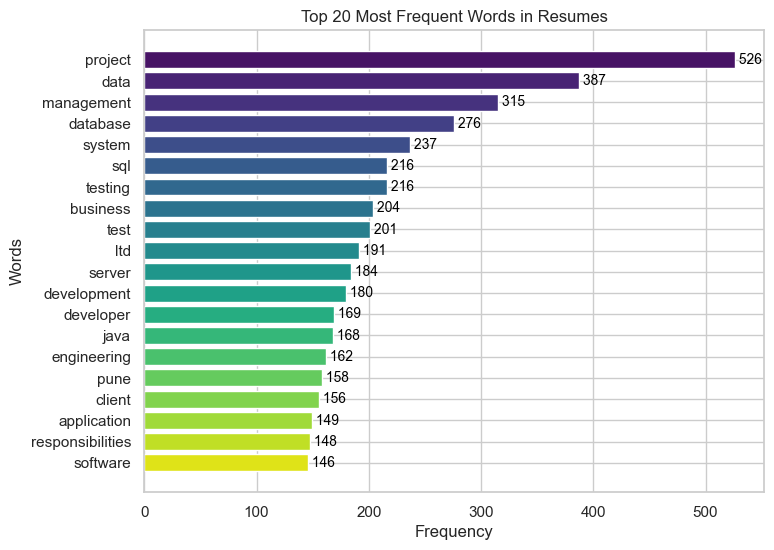

In [751]:
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]
sns.set(style="whitegrid")

palette = sns.color_palette("viridis", n_colors=len(words))

plt.figure(figsize=(8, 6))
bars = plt.barh(words, frequencies, color=palette)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words in Resumes')
plt.gca().invert_yaxis()  

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f' {bar.get_width():.0f}', 
             va='center', ha='left', color='black', fontsize=10)
plt.show()

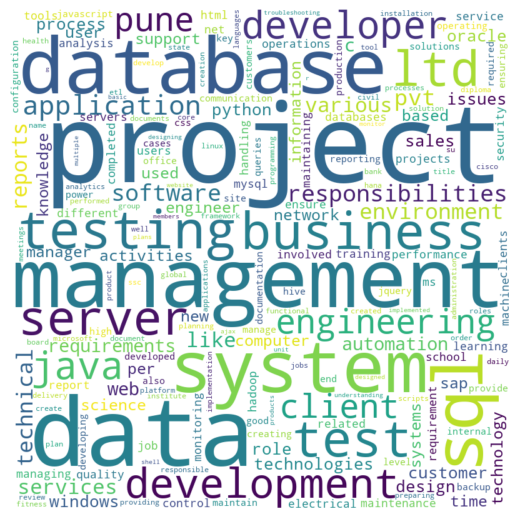

In [752]:
#As a complement to the previous step, this WordCloud is generated with the aim of providing an intuitive visual representation of the most frequent words in the processed resumes.
#The WordCloud offers an immediate way to discern which terms are most prominent in the dataset, highlighting the most frequent terms with larger sizes.
unigram_freq = Counter({word: freq for word, freq in word_freq.items() if ' ' not in word})

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10)
wordcloud.generate_from_frequencies(unigram_freq)

plt.figure(figsize=(5, 5), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')  #interpolation='bilinear' para suavizar os pixels das palavras
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


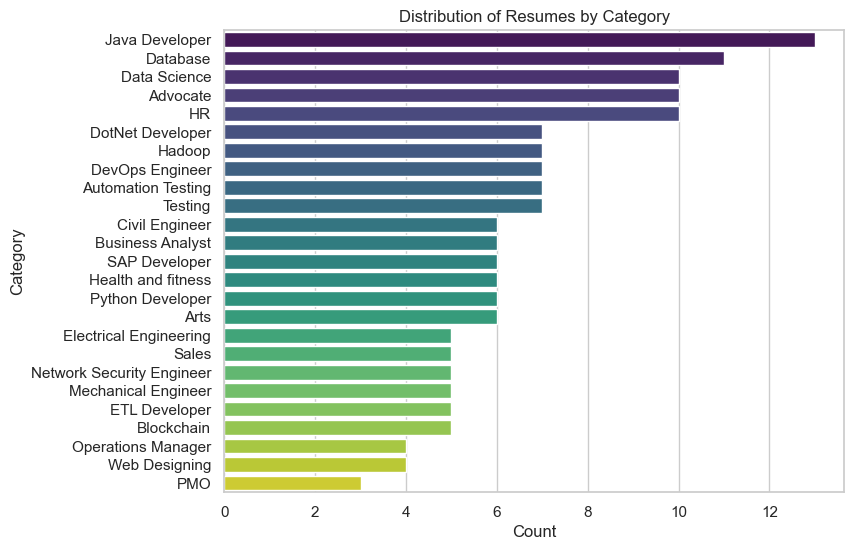

In [753]:
#The purpose of this visualization is to present the distribution of resumes by category in a clear and intuitive manner.
#I chose a horizontal bar chart for this task due to its effectiveness in displaying categories that may have long names (which is common in resume data).

#Horizontal bar charts were chosen because they are particularly useful when dealing with a significant number of categories.
#They facilitate the reading of category names and the relative comparison of their counts. 

plt.figure(figsize=(8,6))
sns.barplot(x=category['count'], y=category['Category'], hue=category['Category'], palette='viridis', legend=False)
plt.title('Distribution of Resumes by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

### Explain the rationale of your decision about techniques and visualizations

> Initially, I removed duplicate records to ensure the integrity of the dataset. Then, I carried out meticulous preprocessing, removing undesirable characters such as symbols, URLs, hashtags, mentions, and extra spaces. These actions are conventional steps in text processing aimed at refining the data for subsequent analysis.

> With the intention of focusing the analysis on the most significant words pertinent to the context of resume categorization, I chose to exclude a set of manually selected stopwords. This decision was made despite the inherent ability of TF-IDF to discern and weigh the relevance of terms within the corpus. The removal of these words was a strategic step to enhance the accuracy of the NLP model to be applied, focusing on key terms that could denote specific categories and facilitate the identification of relevant patterns.

> The Tokenizer was employed to measure the frequency of the words present in the resumes.

> The selected visualizations, including distribuition graphs and word cloud, provided a graphical view of the trends observed in the data. These representations not only intuitively highlighted the most prevalent terms but also facilitated the recognition of patterns and assisted in generating valuable insights, laying a solid foundation for subsequent modeling.

- Note: The code includes additional comments explaining the purpose and reason behind the choice of techniques.

## 2 - NLP/ML Approach

## 2.1 - First Approach (TF-IDF + KMeans)

The specific objective is to use the KMeans clustering algorithm to group resumes into distinct categories based on their textual features. This grouping will help us understand underlying patterns and trends in the dataset, as well as check the consistency of existing resume categories.


#### Algorithm Overview

1. TF-IDF Transformation: Convert the processed resumes into a TF-IDF feature matrix, highlighting the relative importance of words.

2. Validate how the data varies with the increase in the number of clusters (Silhouette and Elbow Method).

3. KMeans Model Training: Apply the KMeans algorithm to the vectorized data.

4. Comparison with Existing Categories: Compare the clusters formed with the original resume categories to check for consistency and identify discrepancies.


I have chosen a number of clusters equal to the number of existing categories to directly verify the correspondence between the clusters generated by KMeans and the predefined categories.

K=2, Silhouette Score=0.024680061937376974
K=3, Silhouette Score=0.02686409164856881
K=4, Silhouette Score=0.031038398569260037
K=5, Silhouette Score=0.03784920137684158
K=6, Silhouette Score=0.04245844439983774
K=7, Silhouette Score=0.04791023765474723
K=8, Silhouette Score=0.05177342468552381
K=9, Silhouette Score=0.057391380646655256
K=10, Silhouette Score=0.06346141427788798
K=11, Silhouette Score=0.07071493259102128
K=12, Silhouette Score=0.07262826133473499
K=13, Silhouette Score=0.08087462863562367
K=14, Silhouette Score=0.08236977695812532
K=15, Silhouette Score=0.08632881017778089
K=16, Silhouette Score=0.09092477862527062
K=17, Silhouette Score=0.08816886922927689
K=18, Silhouette Score=0.10086449672013356
K=19, Silhouette Score=0.0966757168660652
K=20, Silhouette Score=0.10467650928484129
K=21, Silhouette Score=0.11198338417774766
K=22, Silhouette Score=0.10808460566389416
K=23, Silhouette Score=0.1055430046371459
K=24, Silhouette Score=0.09983407932180516
K=25, Silhouette S

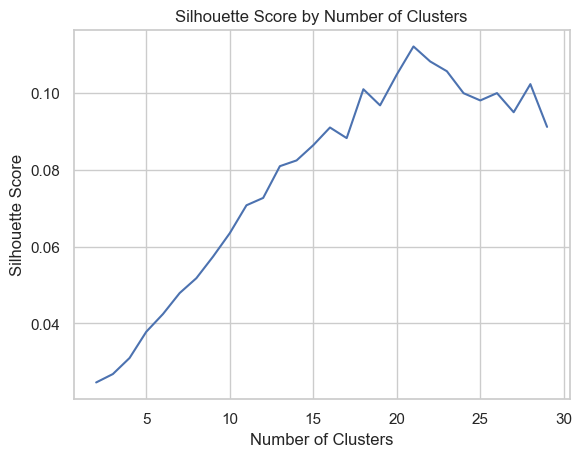

In [754]:
#The silhouette analysis serves as an exploratory tool to understand the cohesion and separation of the clusters,
#helping to identify the optimal number of clusters that best capture the underlying structure of the data.
vectorizer = TfidfVectorizer(
                            ngram_range=(1, 3), 
                            max_features=1000, 
                            )


X = vectorizer.fit_transform(data['Resume_Processed'])

k_values = range(2, 30)

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=40)
    y_kmeans = kmeans.fit_predict(X)  
    score = silhouette_score(X, y_kmeans)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score}")

plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True)
plt.show()


In [755]:
#I chose to implement 25 clusters in the KMeans analysis to corroborate the 25 predefined categories of the dataset. 
#Silhouette analysis, which is commonly used to define the ideal number of clusters based on their cohesion and separation, was considered but not as the sole factor in this situation. 
#The choice was intentionally designed to align with the already established categories, with the purpose of investigating whether such groupings occur organically within the data.

#Even though the silhouette did not indicate the number 25 as the optimal peak, the reason for adopting this specific number of clusters was the possibility of conducting 
#a direct comparison between the groupings formed by KMeans and the existing categories, thus providing an examination of the natural clustering tendency of the resumes in the dataset.

#The visualization of the silhouette graph allowed us to monitor the variations in information as we increased the number of clusters. 
#This visual observation was crucial to ensure that the decision to use 25 clusters did not result in a significantly incoherent segmentation of the data, thus offering an additional validation of the choice made.

k = 25
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=40) 
y_kmeans = kmeans.fit_predict(X)

centroids = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()

for i in range(k):  
    print(f"Cluster {i}:")
    centroid = centroids[i]
    sorted_terms = [terms[j] for j in centroid.argsort()[::-1]]
    print(sorted_terms[:10])

Cluster 0:
['sap', 'hana', 'bo', 'bods', 'data', 'sap hana', 'sap bo', 'consultant', 'project', 'reports']
Cluster 1:
['java', 'servlet', 'amravati', 'web', 'jsp', 'learn', 'strengths', 'computer', 'matlab', 'technologies']
Cluster 2:
['project', 'made', 'matlab', 'matrix', 'major', 'application', 'computer', 'sap', 'pune', 'developer']
Cluster 3:
['advocate', 'law', 'court', 'district', 'board', 'drafting', 'chennai', 'cases', 'ounts', 'authority']
Cluster 4:
['server', 'sql', 'database', 'sql server', 'servers', 'log shipping', 'installation', 'log', 'dr', 'shipping']
Cluster 5:
['business', 'management', 'project', 'operations', 'report', 'ltd', 'analyst', 'process', 'business analyst', 'sales']
Cluster 6:
['net', 'dot', 'dot net', 'web', 'sql', 'developer', 'pune', 'jquery', 'sql server', 'net developer']
Cluster 7:
['hadoop', 'hive', 'data', 'hdfs', 'sqoop', 'mapreduce', 'cluster', 'spark', 'pig', 'hbase']
Cluster 8:
['data', 'data science', 'python', 'learning', 'machine learning

In [756]:
#Maps each cluster to the most similar resume category based on TF-IDF vectorization and cosine similarity.
#It iterates through each cluster, comparing to unique resume categories to find the best match.
cluster_category_data = []

warnings.filterwarnings('ignore', category=FutureWarning)

for cluster in range(k):  
    sorted_terms_cluster = [terms[j] for j in centroids[cluster].argsort()[::-1]][:10]
    vectorizer = TfidfVectorizer(vocabulary=sorted_terms_cluster, lowercase=True)
    resume_vectors = vectorizer.fit_transform(data['Resume_Processed'])
    sorted_terms_vector = vectorizer.transform([' '.join(sorted_terms_cluster)])
    category_similarity = pd.DataFrame(columns=['Category', 'Average_Similarity'])

    for category in data['Category'].unique():
        category_data = data[data['Category'] == category]
        category_vectors = vectorizer.transform(category_data['Resume_Processed'])
        similarity_scores = cosine_similarity(category_vectors, sorted_terms_vector)
        average_similarity = np.mean(similarity_scores)
        new_row = pd.DataFrame({'Category': [category], 'Average_Similarity': [average_similarity]})
        category_similarity = pd.concat([category_similarity, new_row], ignore_index=True)

    top_category = category_similarity.sort_values(by='Average_Similarity', ascending=False).iloc[0]
    cluster_category_data.append({'Cluster': cluster, 'Top_Category': top_category['Category']})

In [757]:
cluster_category_df = pd.DataFrame(cluster_category_data)
cluster_category_df


,Cluster,Top_Category
0,0,SAP Developer
1,1,Java Developer
2,2,SAP Developer
3,3,Advocate
4,4,Database
5,5,Business Analyst
6,6,DotNet Developer
7,7,Hadoop
8,8,Data Science
9,9,Electrical Engineering


In [758]:
#Simply checking which categories were left out of the clusters, that is, which 'Category' values are not present in 'Top_Category'.
unique_real_categories = set(data['Category'].unique())
unique_top_categories = set(cluster_category_df['Top_Category'].unique())
categories_not_in_top = unique_real_categories.difference(unique_top_categories)
categories_not_in_top_list = list(categories_not_in_top)
print(categories_not_in_top_list)

['DevOps Engineer', 'Web Designing', 'Operations Manager', 'PMO']


In [771]:
data[data['Category'] == 'Web Designing']

,index,Category,Resume,Resume_Processed,Closest_Cluster,Top_Category
36,140,Web Designing,"Technical Skills Web Technologies: Angular JS,...",technical web technologies angular js html css...,2,SAP Developer
37,141,Web Designing,Education Details \r\n B.C.A Bachelor Computer...,bca bachelor computer application pune pune hs...,6,DotNet Developer
38,143,Web Designing,Education Details \r\nJanuary 2016 B.Sc. Infor...,bsc information technology hsc allahabad uttar...,6,DotNet Developer
39,144,Web Designing,"IT SKILLS Languages: C (Basic), JAVA (Basic) W...",languages c basic java basic web technologies ...,6,DotNet Developer


In [760]:
#Calculates the cosine similarity between the TF-IDF vectors of the resumes (X) and the centroids of the clusters found by KMeans. 
#It then assigns each resume to the closest cluster and maps these clusters to the corresponding top categories they represent, updating the dataset with this categorical information.

similarities = cosine_similarity(X, centroids)
closest_clusters = np.argmax(similarities, axis=1)
data['Closest_Cluster'] = closest_clusters
cluster_to_category = dict(zip(cluster_category_df['Cluster'], cluster_category_df['Top_Category']))
data['Top_Category'] = data['Closest_Cluster'].map(cluster_to_category)

Agreement Rate: 0.81


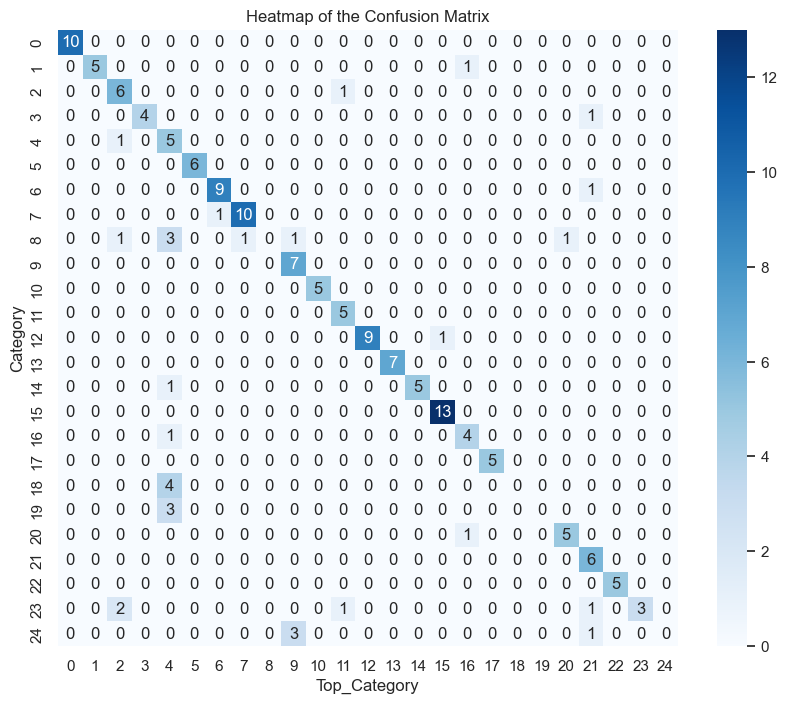

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00        10
                     Arts       1.00      0.83      0.91         6
       Automation Testing       0.60      0.86      0.71         7
               Blockchain       1.00      0.80      0.89         5
         Business Analyst       0.29      0.83      0.43         6
           Civil Engineer       1.00      1.00      1.00         6
             Data Science       0.90      0.90      0.90        10
                 Database       0.91      0.91      0.91        11
          DevOps Engineer       0.00      0.00      0.00         7
         DotNet Developer       0.64      1.00      0.78         7
            ETL Developer       1.00      1.00      1.00         5
   Electrical Engineering       0.71      1.00      0.83         5
                       HR       1.00      0.90      0.95        10
                   Hadoop       1.00      1.00      1.00     

c:\Users\kevyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kevyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kevyn\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [761]:
#Calculates the confusion matrix between the actual categories of the resumes and the categories predicted by the clustering process.

#It also calculates the agreement rate, which is the proportion of resumes that were correctly categorized by the clustering process.

#The heatmap visualizes the confusion matrix, highlighting the matches between the actual and predicted categories. We can see that the diagonal has the highest number of matches, 
#which is consistent with an agreement rate of 84%.

conf_matrix = confusion_matrix(data['Category'], data['Top_Category'])
agreement_rate = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f'Agreement Rate: {agreement_rate:.2f}')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Heatmap of the Confusion Matrix')
plt.ylabel('Category')
plt.xlabel('Top_Category')
plt.show()

print(classification_report(data['Category'], data['Top_Category']))

In [772]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(data['Category'], data['Top_Category'])

0.6946062198989399

In [762]:
#Creating a dataframe to better visualize the count of 'Category' and 'Top_Category', as we can see, there is a difference in some 'Category' values, with no corresponding match in 'Top_Category'.

category_counts = data['Category'].value_counts()
top_category_counts = data['Top_Category'].value_counts()

counts_df = pd.DataFrame({'Category_Count': category_counts, 'Top_Category_Count': top_category_counts})
counts_df['Top_Category_Count'] = counts_df['Top_Category_Count'].fillna(0).astype(int)
counts_df

,Category_Count,Top_Category_Count
Advocate,10,10
Arts,6,5
Automation Testing,7,10
Blockchain,5,4
Business Analyst,6,17
Civil Engineer,6,6
Data Science,10,10
Database,11,11
DevOps Engineer,7,0
DotNet Developer,7,11


# 2.2 - Testing

Quero testar o que justifica alguns curriculos serem reatribuidos para outras categorias. Por exemplo: Todos os curriculos de Web Designing foram realocados para DotNet Developer e os curriculos de DevOps Engineer foram realocados para diversas outras categorias.

1. Checar a similaridade entre a categoria Web Designin e DotNet Developer 
2. Checar a similaridade de cada curriculo individual de DevOps Engineer

In [763]:
data = data.reset_index()

In [764]:
data[data['Category'] == 'Business Analyst']

,index,Category,Resume,Resume_Processed,Closest_Cluster,Top_Category
75,403,Business Analyst,Education Details \r\n BE Computer Science Mum...,computer science hsc state board ssc state boa...,5,Business Analyst
76,404,Business Analyst,"Technical Skills Application Servers: IIS 6.0,...",technical application servers iis jboss databa...,5,Business Analyst
77,405,Business Analyst,Key Skills - Requirement Gathering - Requireme...,key requirement gathering requirement analysis...,5,Business Analyst
78,406,Business Analyst,IT Skills: Area Exposure Modeling Tool: Bizagi...,area exposure modeling tool bizagi ms visio pr...,17,Automation Testing
79,407,Business Analyst,TECHNOLOGICAL SKILLS â¦ Knowledge of Computer...,technological knowledge computers windows plat...,5,Business Analyst
80,408,Business Analyst,Education Details \r\nFebruary 2006 to Februar...,tybcom commerce business analyst business anal...,5,Business Analyst


In [765]:
# Just checking if there is a significant difference that justifies the relocation of the "Web Designing" category to "DotNet Developer." 
# The goal is to assess the similarity between "Web Designing" and all other categories, verifying if the highest similarity occurs with the "DotNet Developer" category.
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Resume_Processed'])
web_designing_resumes = data[data['Category'] == 'Business Analyst']['Resume_Processed']
web_designing_tfidf = tfidf_vectorizer.transform(web_designing_resumes)

category_similarities = {}

for category in data['Category'].unique():
    if category != 'Web Designing':
        category_resumes = data[data['Category'] == category]['Resume_Processed']
        category_tfidf = tfidf_vectorizer.transform(category_resumes)
        cosine_similarities = cosine_similarity(web_designing_tfidf, category_tfidf)
        average_similarity = np.mean(cosine_similarities)
        category_similarities[category] = round(average_similarity, 2)  

sorted_categories = sorted(category_similarities.items(), key=lambda x: x[1], reverse=True)
for category, similarity in sorted_categories:
    print(f"{category}: {similarity}")

Business Analyst: 0.3
PMO: 0.14
Automation Testing: 0.11
Operations Manager: 0.11
DevOps Engineer: 0.09
Database: 0.07
Testing: 0.07
SAP Developer: 0.06
ETL Developer: 0.06
Data Science: 0.05
Mechanical Engineer: 0.05
Sales: 0.05
Java Developer: 0.05
Python Developer: 0.05
Hadoop: 0.05
DotNet Developer: 0.05
Civil Engineer: 0.04
Electrical Engineering: 0.04
Network Security Engineer: 0.04
Blockchain: 0.04
Health and fitness: 0.03
HR: 0.02
Advocate: 0.02
Arts: 0.02


## 2.2 - Explain the rationale of your NLP techniques/ML models usage and conclusions
#### NLP/ML

1.  TF-IDF Vectorization: I chose to use TF-IDF (Term Frequency-Inverse Document Frequency) for its effectiveness in highlighting important words in each resume, considering not only the frequency of these words but also their rarity across the entire dataset. This technique is particularly advantageous in resume analyses, as it allows for the identification of technical terms and specific skills crucial in differentiating candidates. Unlike other approaches, such as simple word counting, TF-IDF provides a deeper and more contextual understanding of the words, prioritizing terms that are distinctive and relevant to each category.

2. Silhouette Method:
The choice of the silhouette method to evaluate how data varies with the increase in the number of clusters was strategic, although it was not the decisive criterion for choosing the number of clusters. The purpose of this analysis was to check if the use of 25 clusters, aligned with the 25 pre-existing categories in the dataset, was a reasonable decision. The silhouette analysis helped to ensure that, despite not being the optimal number according to this method, the choice of 25 clusters did not result in an extremely inappropriate grouping of the data.

3. KMeans Clustering:
The use of the K-Means clustering method was motivated by its efficiency and simplicity in grouping high-dimensional data, such as resumes transformed via TF-IDF. K-Means is known for its ability to form distinct clusters and its ease of implementation and interpretation. Compared to other more complex clustering methods, K-Means offers a balance between computational efficiency and clarity of results, making it a suitable choice for the task of grouping resumes into predefined categories.

5. Confusion Matrix and Performance Metrics:
The confusion matrix was used to concisely and effectively evaluate the performance of the K-Means clustering model. This method allows for visualizing and comparing the actual categories of the resumes ('Category') with the categories assigned by the model ('Top_Category'). Through it, it is possible to identify not only the correct classifications (main diagonal) but also the classification errors, providing a clear understanding of which categories were correctly grouped and which showed discrepancies. This type of analysis is fundamental for evaluating the accuracy of the model and guiding potential adjustments or improvements in the clustering process.

#### Conclusions

The purpose of this work was to use the KMeans algorithm to group the resumes into 25 distinct clusters. The main goal of this approach was to compare the resulting clusters with the 25 pre-existing categories, in order to assess the correspondence and effectiveness of the clustering in reflecting the already established categories.

The study concluded with an agreement rate of 81%, showing a good match between the existing resume categories in the dataset and those identified by the KMeans clustering model. The effectiveness of the model was particularly evident in categories with greater representation in the dataset, such as 'Advocate', 'Sales', 'Hadoop' etc, where it achieved perfect precision and recall rates.

However, the study also highlighted certain limitations of the KMeans application, particularly in the following aspects:

- Handling Less Represented Categories: The algorithm tends to favor forming clusters of similar sizes, posing challenges in cases where there is significant variation in the number of resumes per category.

- Accuracy in Certain Categories: Categories like 'DevOps Engineer' and 'Operations Manager', which were less represented in the dataset, did not achieve accurate classification, indicating difficulties in identifying distinct patterns in these less popular categories.

The decision to use 25 clusters in the analysis, although not indicated as ideal by the silhouette analysis, had significant implications on the calculation of similarities with the pre-existing categories in the dataset. This choice, primarily guided by the goal of aligning the clusters with the 25 predefined categories, might have led to a forced representation of the natural divisions in the data.

In particular, this approach might have caused an artificial correspondence between the clusters and categories, where resumes that would naturally belong to different groups were forced to fit into predefined categories. This could have resulted in some discrepancies in the similarity analysis, especially in less represented categories or those with more distinct characteristics.

Upon analyzing the model's results, it becomes clear that there is a potential overlap in the skills and experiences described in some resume categories. This suggests the need to reevaluate and potentially redefine these categories. Redefining may involve merging similar categories or creating new ones that better reflect current market trends and needs. A more precise and updated approach to categorizing will not only improve resume analysis but also provide clearer insights into the job market.

A future perspective to enhance the code and approach used in this study involves exploring and comparing other advanced NLP and clustering techniques to improve the accuracy and effectiveness of resume analysis. Here are some possibilities:

- Experimenting with Different Clustering Methods: In addition to KMeans, other algorithms like DBSCAN, Agglomerative Clustering, or Spectral Clustering could be explored. These methods might handle clusters of varying sizes and shapes better and could offer different insights into the data structure.

- Using Dimensionality Reduction: Techniques such as PCA (Principal Component Analysis) or t-SNE could be applied to reduce the data's dimensionality before clustering. This might help improve the performance of algorithms on complex, high-dimensional datasets.

- Incorporating Text Embedding Models: Models like Word2Vec, BERT, or GloVe could be used to create more sophisticated embeddings of the resumes. These models better capture the context and semantic relationships of words, which could enrich the analysis.

- Topic Analysis: Methods such as LDA (Latent Dirichlet Allocation) or NMF (Non-negative Matrix Factorization) could be employed for a more granular view of specialization areas and skills in the resumes.

- Cross-Evaluation with Other Metrics: Using other evaluation metrics like the Davies-Bouldin Index or Calinski-Harabasz Index could offer an additional perspective on the suitability of the number of clusters and the quality of clustering.

- Fine-Tuning and Hyperparameter Optimization: Fine-tuning the hyperparameters of the clustering and vectorization models could significantly improve the results.

# 3 - Extra: Similarity analysis

### Resume Screening

> The goal is to conduct a detailed analysis of each resume in the dataset to assess its alignment with a predefined set of skills. 

>This approach is particularly beneficial for efficiently identifying resumes that match the skill requirements of a specific job position.

In [766]:
data.head()

,index,Category,Resume,Resume_Processed,Closest_Cluster,Top_Category
0,0,Data Science,Skills * Programming Languages: Python (pandas...,programming languages python pandas numpy scip...,8,Data Science
1,1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,uitrgpv data scientist data scientist matelabs...,8,Data Science
2,2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...,8,Data Science
3,3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,r python sap hana tableau sap hana sql sap han...,0,SAP Developer
4,4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",mca ymcaust faridabad haryana data science int...,8,Data Science


In [769]:
#To maintain consistency, as I am initiating a new, simpler approach, I have opted to reinitialize the TF-IDF Vectorizer.
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Resume_Processed'])

#List of Desired Skills in the Resume
skills = ['python', 'machine learning', 'deep learning', 'sql']

skills_tfidf = tfidf_vectorizer.transform([' '.join(skills)])
cosine_similarities = cosine_similarity(skills_tfidf, tfidf_matrix).flatten()

num_top_resumes = 10  
top_resume_indices = cosine_similarities.argsort()[-num_top_resumes:][::-1]
top_resumes = data.iloc[top_resume_indices]
top_resumes_similarity = cosine_similarities[top_resume_indices]
top_resumes_full_details = top_resumes[['Category', 'Top_Category', 'Resume_Processed']].copy()
top_resumes_full_details['Similarity'] = top_resumes_similarity
#top_resumes_full_details.reset_index(drop=True, inplace=True)
top_resumes_full_details

,Category,Top_Category,Resume_Processed,Similarity
7,Data Science,Data Science,btech rayat bahra institute engineering biotec...,0.491475
8,Data Science,Data Science,personal ability quickly grasp technical aspec...,0.436309
6,Data Science,Data Science,python tableau data visualization r studio mac...,0.255106
5,Data Science,Data Science,c basics iot python matlab data science machin...,0.249613
2,Data Science,Data Science,areas interest deep learning control system de...,0.246260
134,Database,Data Science,technical sql oracle v v v r programming pytho...,0.205361
105,Python Developer,Python Developer,technical proficiencies platform ubuntufedorac...,0.160849
1,Data Science,Data Science,uitrgpv data scientist data scientist matelabs...,0.152659
9,Data Science,Data Science,expertise data quantitative analysis decision ...,0.137293
103,Python Developer,Python Developer,technical responsibilities hands production ma...,0.123679
